In [22]:
import yfinance as yf

nifty50 = yf.Ticker("^NSEI")

In [87]:
from datetime import datetime, timedelta

# sbilife = yf.Ticker("AAPL")
sbilife = yf.Ticker("SBILIFE.NS")
# pprint.pprint(sbilife.history_metadata)
# sbilife.history(interval="1d", start="2021-01-01", end="2021-01-10")
sbilife.history(interval="1d", start="2021-01-01")
now = datetime.now()
start_date = now - timedelta(days=729)
end_date = now
data = sbilife.history(
    interval="30m",
    period="1mo",
    actions=True,
    prepost=True,
    auto_adjust=True,
    repair=True,
)

/home/sps/ProgramFiles/anaconda/anaconda3/envs/ibkr/lib/python3.9/site-packages/yfinance/scrapers/history.py:239: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  quotes2 = quotes.resample('30T')


In [88]:
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Repaired?
Datetime,,,,,,,,
2024-05-06 09:00:00+05:30,1452.650024,1456.900024,1447.449951,1453.949951,43510,0.0,0.0,False
2024-05-06 09:30:00+05:30,1453.599976,1454.599976,1437.000000,1439.449951,145962,0.0,0.0,False
2024-05-06 10:00:00+05:30,1439.849976,1439.849976,1433.150024,1434.900024,51927,0.0,0.0,False
2024-05-06 10:30:00+05:30,1434.900024,1444.250000,1432.000000,1441.949951,65364,0.0,0.0,False
2024-05-06 11:00:00+05:30,1441.449951,1444.849976,1435.349976,1439.750000,71409,0.0,0.0,False
...,...,...,...,...,...,...,...,...
2024-06-05 13:00:00+05:30,1376.900024,1387.150024,1376.500000,1385.000000,57541,0.0,0.0,False
2024-06-05 13:30:00+05:30,1385.849976,1387.000000,1367.650024,1378.599976,165056,0.0,0.0,False
2024-06-05 14:00:00+05:30,1378.599976,1394.000000,1378.599976,1390.900024,114254,0.0,0.0,False


{'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36', 'If-Modified-Since': 'Fri, 07 Jun 2024 02:57:06 GMT'}
Fri, 07 Jun 2024 02:57:12 GMT
Modified
{'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36', 'If-Modified-Since': 'Fri, 07 Jun 2024 02:57:12 GMT'}
Fri, 07 Jun 2024 03:05:23 GMT
Modified
{'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36', 'If-Modified-Since': 'Fri, 07 Jun 2024 03:05:23 GMT'}
Fri, 07 Jun 2024 03:05:24 GMT


/home/sps/ProgramFiles/anaconda/anaconda3/envs/ibkr/lib/python3.9/site-packages/yfinance/scrapers/history.py:239: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  quotes2 = quotes.resample('30T')


Modified


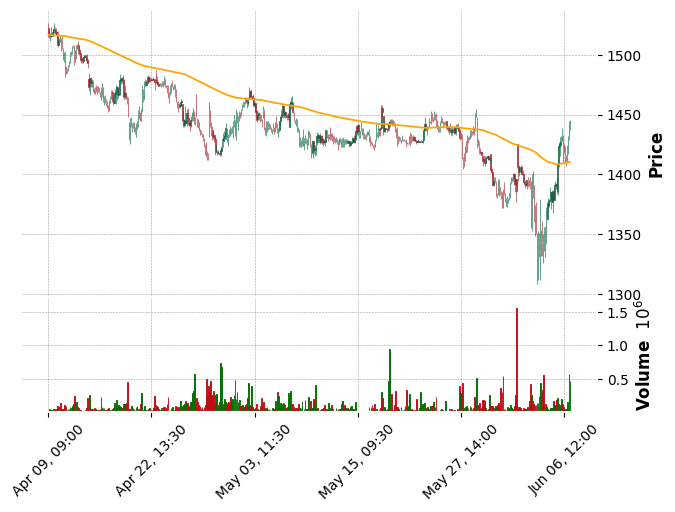

In [21]:
import yfinance as yf
from datetime import datetime, timedelta
from requests import Session
from requests_cache import CacheMixin, SQLiteCache
from requests_ratelimiter import LimiterMixin, MemoryQueueBucket
from pyrate_limiter import Duration, RequestRate, Limiter
import matplotlib.pyplot as plt
import mplfinance as mpf


class CachedLimiterSession(CacheMixin, LimiterMixin, Session):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def request(self, method, url, *args, **kwargs):
        # Get the cached response, if available
        cached_response = self.cache.get_response(url)
        headers = kwargs.get("headers", {})
        print(headers)

        if cached_response:
            # etag = cached_response[0].headers.get("ETag")
            headers["If-Modified-Since"] = cached_response.headers["date"]

            # print(etag)
            print(headers["If-Modified-Since"])

            # if etag:
            # headers["If-None-Match"] = etag
            # kwargs["headers"] = headers

        response = super().request(method, url, *args, **kwargs)

        if response.status_code == 304:
            # Not modified, use the cached response
            response = cached_response[0]
            print("Not modified")
        else:
            # Update the cache with the new response
            self.cache.save_response(response, cache_key=url)
            print("Modified")

        return response


session = CachedLimiterSession(
    limiter=Limiter(
        RequestRate(2, Duration.SECOND * 5)
    ),  # max 2 requests per 5 seconds
    bucket_class=MemoryQueueBucket,
    backend=SQLiteCache("yfinance.cache.db"),
    # expire_after=timedelta(days=1),
)

session.headers["User-agent"] = "yfinaince-cache/1.0"
company = yf.Ticker("SBILIFE.NS", session=session)

now = datetime.now()
start_date = now - timedelta(days=59)
end_date = now

data_30m60day = company.history(
    interval="30m",
    start=start_date,
    end=end_date,
    actions=True,
    prepost=True,
    auto_adjust=True,
    repair=True,
)

data_30m60day["Ticker"] = "SBILIFE.NS"
# Calculate the 200 period  exponential moving average
ema_200_intraday = data_30m60day["Close"].ewm(span=200, adjust=False).mean()
data_30m60day["ema_200"] = ema_200_intraday
data_30m60day["Trend"] = data_30m60day["Close"] > data_30m60day["ema_200"]
data_30m60day["Bullish"] = data_30m60day["Close"] > data_30m60day["ema_200"]
data_30m60day["Bearish"] = data_30m60day["Close"] < data_30m60day["ema_200"]


# Check if the trend is bullish for intraday
is_bullish = (
    data_30m60day["Bullish"].tail(10).sum() > 10
    and data_30m60day["Bullish"].tail(100).sum() > 70
)


data_for_plot_intraday = data_30m60day[
    ["Open", "High", "Low", "Close", "Volume", "ema_200"]
]
ema_plot_intraday = mpf.make_addplot(data_for_plot_intraday["ema_200"], color="orange")
mpf.plot(
    data_for_plot_intraday,
    type="candle",
    style="charles",
    volume=True,
    addplot=ema_plot_intraday,
)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 507 entries, 2024-04-09 09:00:00+05:30 to 2024-06-06 15:00:00+05:30
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          507 non-null    float64
 1   High          507 non-null    float64
 2   Low           507 non-null    float64
 3   Close         507 non-null    float64
 4   Volume        507 non-null    int64  
 5   Dividends     507 non-null    float64
 6   Stock Splits  507 non-null    float64
 7   Repaired?     507 non-null    bool   
 8   Ticker        507 non-null    object 
 9   ema_200       507 non-null    float64
 10  Trend         507 non-null    bool   
 11  Bullish       507 non-null    bool   
 12  Bearish       507 non-null    bool   
dtypes: bool(4), float64(7), int64(1), object(1)
memory usage: 41.6+ KB


{'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36', 'If-Modified-Since': 'Fri, 07 Jun 2024 03:13:04 GMT'}
Fri, 07 Jun 2024 03:14:17 GMT
Modified


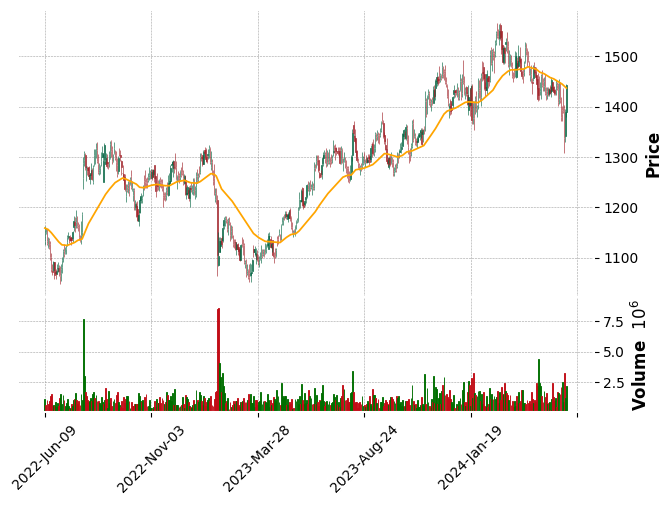

In [36]:
start_date = now - timedelta(days=729)
data_1d730day = company.history(
    interval="1d",
    start=start_date,
    end=end_date,
    actions=True,
    prepost=True,
    auto_adjust=True,
    repair=True,
)

ema_50_swing = data_1d730day["Close"].ewm(span=50, adjust=False).mean()
data_1d730day["ema_50"] = ema_50_swing
data_1d730day["Trend"] = data_1d730day["Close"] > data_1d730day["ema_50"]
data_1d730day["Bullish"] = data_1d730day["Close"] > data_1d730day["ema_50"]
data_1d730day["Bearish"] = data_1d730day["Close"] < data_1d730day["ema_50"]


# Check if the trend is bullish for swing
is_bullish_swing = (
    data_1d730day["Bullish"].tail(10).sum() > 10
    and data_1d730day["Bullish"].tail(100).sum() > 70
)

data_for_plot_swing = data_1d730day[
    ["Open", "High", "Low", "Close", "Volume", "ema_50"]
]
ema_plot_swing = mpf.make_addplot(data_for_plot_swing["ema_50"], color="orange")
mpf.plot(
    data_for_plot_swing,
    type="candle",
    style="charles",
    volume=True,
    addplot=ema_plot_swing,
)

In [37]:
data_1d730day

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Repaired?,ema_50,Trend,Bullish,Bearish
Date,,,,,,,,,,,,
2022-06-09 00:00:00+05:30,1132.252370,1162.427227,1125.878910,1158.891846,1142045,0.0,0.0,False,1158.891846,False,False,False
2022-06-10 00:00:00+05:30,1149.978891,1158.891864,1147.489221,1150.128296,611509,0.0,0.0,False,1158.548177,False,False,True
2022-06-13 00:00:00+05:30,1132.352125,1156.999866,1125.679735,1129.015869,1014220,0.0,0.0,False,1157.390047,False,False,True
2022-06-14 00:00:00+05:30,1120.351845,1140.269211,1119.505381,1127.422485,768306,0.0,0.0,False,1156.214849,False,False,True
2022-06-15 00:00:00+05:30,1135.289755,1139.970287,1118.160870,1121.098633,947417,0.0,0.0,False,1154.837742,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31 00:00:00+05:30,1393.800049,1401.150024,1372.599976,1386.400024,2559060,0.0,0.0,False,1445.012775,False,False,True
2024-06-03 00:00:00+05:30,1435.300049,1436.400024,1387.349976,1391.500000,870693,0.0,0.0,False,1442.914235,False,False,True
2024-06-04 00:00:00+05:30,1398.150024,1402.699951,1307.699951,1338.849976,3277433,0.0,0.0,False,1438.833284,False,False,True


{'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36', 'If-Modified-Since': 'Fri, 07 Jun 2024 03:05:28 GMT'}
Fri, 07 Jun 2024 03:05:28 GMT
Modified


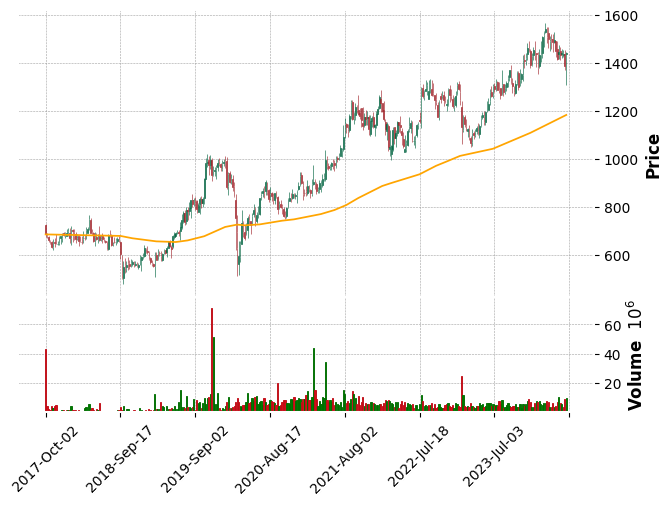

In [44]:
start_date = now - timedelta(days=365 * 5)
data_1wk5yr = company.history(
    interval="1wk",
    period="max",
    actions=True,
    prepost=True,
    auto_adjust=True,
    repair=True,
)

ema_200_positional = data_1wk5yr["Close"].ewm(span=200, adjust=False).mean()
data_1wk5yr["ema_200"] = ema_200_positional
data_1wk5yr["Trend"] = data_1wk5yr["Close"] > data_1wk5yr["ema_200"]
data_1wk5yr["Bullish"] = data_1wk5yr["Close"] > data_1wk5yr["ema_200"]
data_1wk5yr["Bearish"] = data_1wk5yr["Close"] < data_1wk5yr["ema_200"]


# Check if the trend is bullish for positional
is_bullish_positional = (
    data_1wk5yr["Bullish"].tail(10).sum() > 10
    and data_1wk5yr["Bullish"].tail(100).sum() > 70
)

data_for_plot_positional = data_1wk5yr[
    ["Open", "High", "Low", "Close", "Volume", "ema_200"]
]
ema_plot_positional = mpf.make_addplot(
    data_for_plot_positional["ema_200"], color="orange"
)
mpf.plot(
    data_for_plot_positional,
    type="candle",
    style="charles",
    volume=True,
    addplot=ema_plot_positional,
)

In [45]:
data_1wk5yr

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Repaired?,ema_200,Trend,Bullish,Bearish
Date,,,,,,,,,,,,
2017-10-02 00:00:00+05:30,723.989247,728.914344,675.821775,686.312256,43078384,0.0,0.0,False,686.312256,False,False,False
2017-10-09 00:00:00+05:30,683.701908,692.468604,669.813159,679.367859,4367708,0.0,0.0,False,686.243157,False,False,True
2017-10-16 00:00:00+05:30,675.723308,679.121637,654.200658,664.986572,2145239,0.0,0.0,False,686.031649,False,False,True
2017-10-23 00:00:00+05:30,659.962985,663.706047,648.241231,652.279846,1865141,0.0,0.0,False,685.695810,False,False,True
2017-10-30 00:00:00+05:30,655.037915,658.977993,631.495927,632.628723,4672548,0.0,0.0,False,685.167780,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-06 00:00:00+05:30,1450.000000,1465.949951,1413.199951,1431.949951,6406208,0.0,0.0,False,1173.406146,True,True,False
2024-05-13 00:00:00+05:30,1435.000000,1458.199951,1420.150024,1439.849976,5561884,0.0,0.0,False,1176.057329,True,True,False
2024-05-20 00:00:00+05:30,1434.199951,1452.949951,1422.500000,1436.250000,3961301,0.0,0.0,False,1178.646310,True,True,False


In [47]:
from datetime import timezone
import pytz

d1 = data_30m60day.index[0]
d2 = data_30m60day.index[0].tz_convert(timezone.utc)
d3 = data_30m60day.index[0].tz_convert(timezone.utc).to_pydatetime()

ist = pytz.timezone("Asia/Kolkata")

d4 = d2.tz_convert(ist).to_pydatetime()

d5 = d1.to_pydatetime()

d1, d2, d3, d4, d5

(Timestamp('2024-04-08 11:30:00+0530', tz='Asia/Kolkata'),
 Timestamp('2024-04-08 06:00:00+0000', tz='UTC'),
 datetime.datetime(2024, 4, 8, 6, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2024, 4, 8, 11, 30, tzinfo=<DstTzInfo 'Asia/Kolkata' IST+5:30:00 STD>),
 datetime.datetime(2024, 4, 8, 11, 30, tzinfo=<DstTzInfo 'Asia/Kolkata' IST+5:30:00 STD>))

In [93]:
import requests
from bs4 import BeautifulSoup


baseurl = "https://www.nseindia.com/"
url = f"https://www.nseindia.com/market-data/live-equity-market?symbol=NIFTY%2050"
headers = {
    "Host": "www.nseindia.com",
    "User-Agent": "Mozilla/5.0 (X11; Ubuntu; Linuxpprint x86_64; rv:126.0) Gecko/20100101 Firefox/126.0",
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8",
    "Accept-Language": "en-US,en;q=0.5",
    "Accept-Encoding": "gzip, deflate, br, zstd",
    "Referer": "https://www.nseindia.com/market-data/live-market-indices",
    "Connection": "keep-alive",
    "Upgrade-Insecure-Requests": "1",
    "Sec-Fetch-Dest": "document",
    "Sec-Fetch-Mode": "navigate",
    "Sec-Fetch-Site": "same-origin",
    "Sec-Fetch-User": "?1",
    "Priority": "u=1",
    "Pragma": "no-cache",
    "Cache-Control": "no-cache",
    "TE": "trailers",
}
session = requests.Session()
request = session.get(baseurl, headers=headers, timeout=5)
cookies = dict(request.cookies)
response = session.get(url, headers=headers, timeout=5, cookies=cookies)
if response.status_code == 200:
    soup = BeautifulSoup(response.content, "html.parser")
    # Find the table or the section containing the tickers
    table = soup.find("table")  # Adjust this to find the correct table
    print(table)
    tickers = []
    # for row in table.find_all("tr")[1:]:  # Skipping the header row
    # cols = row.find_all("td")
    # if len(cols) > 0:
    #     ticker = cols[0].text.strip()  # Adjust the index based on actual column
    #     tickers.append(ticker)
    # return tickers
    # print(cols)

None


In [6]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support import expected_conditions
from selenium.webdriver.support.wait import WebDriverWait


chrome_driver_executable_path = ChromeDriverManager().install()
service = Service(executable_path=chrome_driver_executable_path)

options = webdriver.ChromeOptions()
options.add_argument("--headless")
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")

driver = webdriver.Chrome(options=options, service=service)
tickers = []


driver.get("https://sg.finance.yahoo.com/quote/%5ENSEI/components/")
driver.set_window_size(1854, 1031)
WebDriverWait(driver, 10).until(
    expected_conditions.presence_of_element_located(
        (By.XPATH, '//div[@id="Main"]//tr[30]//a')
    )
)
for i in range(1, 31):
    tickers.append(driver.find_element(By.XPATH, f'//div[@id="Main"]//tr[{i}]//a').text)
print("{}".format(tickers))

driver.quit()

['BHARTIARTL.NS', 'LT.NS', 'HEROMOTOCO.NS', 'ONGC.NS', 'COALINDIA.NS', 'BRITANNIA.NS', 'HINDALCO.NS', 'INDUSINDBK.NS', 'NTPC.NS', 'BAJAJ-AUTO.NS', 'KOTAKBANK.NS', 'MARUTI.NS', 'ADANIENT.NS', 'RELIANCE.NS', 'WIPRO.NS', 'CIPLA.NS', 'ITC.NS', 'TCS.NS', 'HDFCLIFE.NS', 'ULTRACEMCO.NS', 'LTIM.NS', 'TATACONSUM.NS', 'APOLLOHOSP.NS', 'BAJFINANCE.NS', 'BAJAJFINSV.NS', 'NESTLEIND.NS', 'SHRIRAMFIN.NS', 'TITAN.NS', 'TATASTEEL.NS', 'MM.NS']


In [8]:
import pandas as pd

data = {
    "tickers": tickers,
    "provider": ["Yahoo"] * len(tickers),
    "index": ["^NSEI"] * len(tickers),
}
df = pd.DataFrame(data)
df.to_csv("Nifty50-Tickers.csv", index=False)